In [1]:
import time    
#time measuring decorator that is called as a wrapper by @timeit above func names
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        #print('%r (%r, %r) %2.2f sec' %(method.__name__, args, kw, te-ts))
        print('%r %2.5f sec' %(method.__name__, te-ts))
        return result
    return timed

import matplotlib.pyplot as plt
from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [104]:
import collections as c
import pickle
train = pickle.load( open( "train.p", "rb" ) )
valid = pickle.load( open( "valid.p", "rb" ) )

In [3]:
import nltk 
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams
import re
#nltk.download() #to download averaged perceptron 

In [105]:
def convert(input_list):
    return c.Counter(input_list)

lem = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    #elif treebank_tag.startswith('I') | treebank_tag.startswith('U') | treebank_tag.startswith('C'):
    #    return 'i'
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def process_data(data):
    X = []
    y = []

    for review in data:
        y.append(review[-1])
        #nltk stopword removal as part of pre-processing
        s_filtered = [re.sub(r"[^A-Za-z]+", '', word) for word in review[0:-2]] #eliminate none-alphabetic 
        s_filtered = [word for word in s_filtered if word not in stopwords.words('english')]
        s_filtered = list(filter(None, s_filtered))
        
        #POS tagging then convert to bag of words dicts
        POS_tagged = pos_tag(s_filtered)
        POS_tagged = [(word, p) for word, p in POS_tagged if word.isalpha()]
        
        #lemmad = []
        for word, p in POS_tagged:
            p = get_wordnet_pos(p)
            lemmad.append(lem.lemmatize(word, pos = get_wordnet_pos(p)))
        
        #add bigrams 
        for bgram1, bgram2 in ngrams(s_filtered, 2):
            lemmad.append(bgram1+' '+bgram2)
        X.append(c.Counter(lemmad))
        
        ###vanilla 
        #X.append(c.Counter(review[0:-2]))
    del data
    return X,y

X_train, y_train = process_data(train)
X_valid, y_valid = process_data(valid)

In [5]:
import numpy as np
# Taken from http://web.stanford.edu/class/cs221/ Assignment #2 Support Code

def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

In [6]:
#Pegasos is a SGD SVM using step size rule 1/(lambda*t), run the next version 
@timeit
def pegasos1(X, y, lamb, num_iter):
    w = dict()
    t = 0
    
    for iteration in range(num_iter):
        for j in range(len(X)):
            t += 1
            step = 1/(t*lamb)
            
            if y[j]*dotProduct(w,X[j]) < 1:
                w.update( (y, x*(1-lamb*step)) for y, x in w.items())
                increment(w, step*y[j], X[j])
            else: 
                w.update( (y, x*(1-lamb*step)) for y, x in w.items())
    return w
#pegasos(X_train, y_train, lamb = 1, num_iter = 1)

In [7]:
@timeit
def pegasos2(X, y, lamb, num_iter):
    w = dict()
    W = dict()
    t = 0
    s = 1
    for iteration in range(num_iter):
        for j in range(len(X)):
            t += 1
            step = 1/(t*lamb)
            s *= 1-(step*lamb)
            if s == 0:
                s = 1
                W = dict()
            
            if y[j]*dotProduct(w,X[j]) < 1:
                increment(W, step*y[j]/s, X[j])
            w.update( (y, x*s) for y, x in W.items())
    return w
#w = pegasos2(X_train, y_train, lamb = 1, num_iter = 15)

In [110]:
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
v = DictVectorizer()
X_train_v = v.fit_transform(X_train)
X_valid_v = v.transform(X_valid)

In [9]:
@timeit
def pegasos3(X, y, lamb, num_iter):
    v_loss = []
    t_loss = []
    num_reviews, num_fea = X.shape
    w = np.zeros((1,num_fea))
    W = np.zeros((1,num_fea))
    t = 0
    s = 1
    for iteration in range(num_iter):
        for j in range(X.shape[0]):
            t += 1
            step = 1/(t*lamb)
            s *= 1-(step*lamb)
            if s == 0:
                s = 1
                W = np.zeros((1,num_fea))
            if not (y[j]*(X[j].dot(w.T)) >= 1):
                W += ((step*y[j])/s)*X[j]
                #print(W)
            w = s*W
        v_loss.append(loss(w, X_valid_v, y_valid))
        t_loss.append(loss(w, X, y))
    return v_loss, t_loss, w

In [13]:
v_l, t_l, w = pegasos3(X_train_v, y_train, lamb = 1, num_iter = 1)
#print(v.inverse_transform(w)[0])
c =v.inverse_transform(w)[0]['long able']
a= pegasos1(X_train, y_train, lamb = 1, num_iter = 1)['long able']
b= pegasos2(X_train, y_train, lamb = 1, num_iter = 1)['long able']
print(a, b, c)

'pegasos3' 6.87056 sec
'pegasos1' 136.05831 sec
'pegasos2' 104.81657 sec
-0.0006666666666666668 -0.000666666666666667 -0.000666666666667


In [112]:
def loss(w, X, y):
    #zero one loss of linear predictor
    loss = 0
    for i in range(X.shape[0]):
        loss += y[i] != np.sign((X[i].dot(w.T)))
        # add boolean to loss whenever pred is incorrect 
    return (loss/X.shape[0])[0,0]

def loss2(w, X, y):
    #zero one loss of linear predictor
    loss = 0
    for i in range(len(X)):
        loss += y[i] != np.sign(dotProduct(w, X[i]))
        # add boolean to loss whenever pred is incorrect 
    return (loss/len(X))
#loss(w, X_valid_v, y_valid)

In [ ]:
regularizer = np.logspace(-6, 1, 10)
v_loss = []
t_loss =[]
w = []
for r in regularizer:
    af, sd, w= pegasos3(X_train_v, y_train, lamb = r, num_iter = 10)
    w = v.inverse_transform(w)
    t_loss.append(loss(w, X_train, y_train))
    v_loss.append(loss(w, X_valid, y_valid))
plt.plot(np.log10(regularizer), t_loss, 'k--', label = 'training loss')
plt.plot(np.log10(regularizer), v_loss, 'r', label = 'validation loss')
plt.xlabel('Regularizer in log10')
plt.ylabel('0-1 loss')
plt.legend(loc='left')
plt.show()

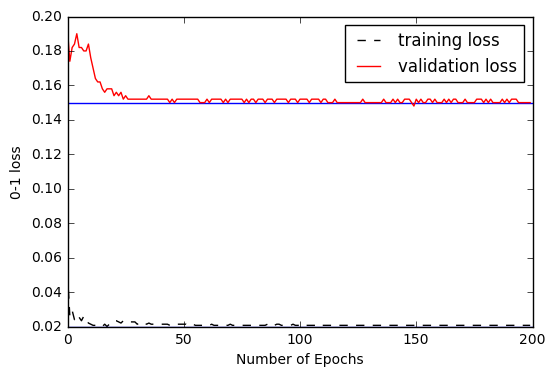

In [41]:
iterations = 200
#v_loss, t_loss, w = pegasos3(X_train_v, y_train, lamb = 1, num_iter = iterations)

plt.plot(range(iterations), t_loss[0:iterations], 'k--', label = 'training loss')
plt.axhline(0.15)
plt.plot(range(iterations), v_loss[0:iterations], 'r', label = 'validation loss')
plt.axhline(0.02)
plt.xlabel('Number of Epochs')
plt.ylabel('0-1 loss')
plt.legend(loc='upper right')
plt.show()

In [84]:
vl, tl, w = pegasos3(X_train_v, y_train, lamb = 1, num_iter = 70) 

'pegasos3' 63.09581 sec


In [86]:
import operator
#error analysis 

def error_analysis(w, X, y):
    #returns indices of worst mistakes
    errors = dict()
    for i in range(len(X)):
        if y[i] != np.sign(dotProduct(w, X[i])):
            errors[i] = abs(dotProduct(w, X[i]))
       
    #object is [(index 1 , |w_1 x_1|), ...  ] sorted on the mistake magnitude
    #take the first 4 of sorted, take the index i argument
    worst = []
    for index, value in sorted(errors.items(), key=lambda e: e[1], reverse = True)[0:3]:
        print(index, value, y[index], np.sign(dotProduct(w, X[index])))
        worst.append(index)
    return worst

indices = error_analysis(w[0], X_train, y_train)
indices

1432 1.44512380952 1 -1.0
372 1.16348571429 1 -1.0
1136 1.06592380952 1 -1.0


[1432, 372, 1136]

In [73]:
for i in indices:
    bad_features = []
    subdic = list(set(w[0].keys()).union(set(X_train[i])))
    occurences = c.Counter(X_train[i])
    for word in subdic:
        bad_features.append([abs(w[0][word]*occurences[word]),  i, word, w[0][word]])
    
    print(sorted(bad_features, key = lambda e: e[0], reverse= True)[0:3])

[[1.9108380952380728, 1432, '.', -0.022219047619047357], [0.31548571428571115, 1432, 'have', -0.052580952380951861], [0.30352380952380892, 1432, 'as', 0.030352380952380891]]
[[0.9554190476190364, 372, '.', -0.022219047619047357], [0.53059047619046562, 372, '"', -0.016580952380952051], [0.48014285714287352, 372, 'and', 0.032009523809524904]]
[[0.73322857142856279, 1136, '.', -0.022219047619047357], [0.42342857142854295, 1136, 'to', -0.023523809523807941], [0.38411428571429884, 1136, 'and', 0.032009523809524904]]


In [98]:
" ".join(train[372][0:-2])

'i didn\'t realize how apt the name of this movie was until i called the mpaa ( the motion picture association of america - the folks who decide what\'s g , nc 17 , pg , r or x ) to ask why the preview was rated r . so that we can make some sense of their response , let me tell you about the movie itself . ; " the celluloid closet " is a documentary about how homosexuality has been portrayed in the movies over the past several decades . ;it\'s brilliant , funny , naughty and extremely poignant . ;it tore at my heart to watch a gifted lesbian screenwriter explain that , as a rule , gay audiences hunger for any hint of homosexuality on screen . ;regardless of how veiled - or how sordid - the presence of a gay or lesbian person allows others to lessen their sense of isolation and makes them feel as if they\'re not quite so invisible as america seems to want them to be . ;the movie itself is rated r - and for good reason . ;it contains scenes of bloody , violent gay bashing and graphic , u

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.